In [1]:
from hyperparameters import STD_MODEL_FOLDER
import json
import os

ModuleNotFoundError: No module named 'hyperparameters'

> run `wandb login` in terminal before running this notebook

### Delete model

In [8]:
# Delete folder from model_development/models
# Delete entry from trained_models.json

def delete_model(model_name):
  model_path = f"{STD_MODEL_FOLDER}/{model_name}"
  assert os.path.exists(model_path), f"Model {model_name} does not exist."
  os.system(f"rm -rf {model_path}")
  with open("./assets/trained_models.json", "r+") as file:
    trained_models = json.load(file)
    if model_name in trained_models:
      del trained_models[model_name]
      file.seek(0)
      json.dump(trained_models, file, indent=4)
      file.truncate()

delete_model("test_yolo_mAP_test3")

AssertionError: Model test_yolo_mAP_test3 does not exist.

## Visualise Dataset

In [1]:
from data.dataset import CustomDataset
from data.yolo_dataset import YoloDataset

#### Full Dataset

In [3]:
training_data = {
            "dataset_name": "p2v5val",
            "datasets": {
                "gfp_belize1": 0,
                "gfp_cook1": 0,
                "gfp_png1": 0,
                "gfp_rand10": 0,
                "gfp_rand6": 0,
                "gfp_rand9": 0,
                "gfp_tiger1": 0,
                "gfp_bahamas2": 0,
                "gfp_caicos1": 0,
                "gfp_cuba1": 0,
                "gfp_madagascar1": 0,
                "gfp_mozambique1": 0,
                "gfp_nwa2": 0,
                "gfp_rand11": 0,
                "gfp_rand4": 0,
                "gfp_rand7": 0,
                "gfp_samoa1": 0,
                "gfp_tobago1": 0,
                "sp_palau5": 0,
                "gfp_caledonia1": 0,
                "gfp_ferdinand1": 0,
                "gfp_jamaica1": 0,
                "gfp_rand1": 0,
                "gfp_rand2": 0,
                "gfp_rand8": 0,
                "shlife_grey2": 0,
                "shlife_grey1": 0,
                "sp_palau": 0,
                "sp_palau4": 0,
                "shlife_scalloped5": 0,
                "gfp_nwa1": 0,
                "shlife_bull1": 0,
                "shlife_bull7": 0,
                "shlife_scalloped1": 0,
                "shlife_smooth1": 0,
                "shlife_bull2": 0,
                "shlife_bull5": 0,
                "shlife_scalloped3": 0,
                "shlife_silvertip1": 0,
                "shlife_smooth3": 0,
                "sp_palau3": 0,
                "sp_palau2": 0,
                "val1_difficult2": 0,
                "val1_easy1": 0,
                "sp_palau6": 0,
                "sp_palau7": 0,
                "sp_palau8": 0,
                "sp_palau9": 0,
                "sp_palau10": 0,
                "sp_natgeo": 0,
                "val1_medium1": 0,
                "gfp_bahamas1": 0,
                "gfp_palau1": 0,
                "shlife_scalloped2": 0,
                "gfp_polynesia1": 0,
                "shlife_bull6": 0,
                "gfp_maldives1": 0,
                "gfp_rand5": 0,
                "gfp_barbados1": 0,
                "val1_easy2": 0,
                "gfp_kiribati1": 0,
                
                "sp_natgeo2": 1,
                "gfp_hawaii1": 1,
                "val1_difficult1": 1,
                "shlife_scalloped4": 1,
                "gfp_fiji1": 1,
                "shlife_smooth2": 1,
                "gfp_niue1": 1,
                "gfp_solomon1": 1,
                "gfp_montserrat1": 1,
                "gfp_rand3": 1,
                "shlife_bull4": 1,
                "gfp_tonga1": 1,
                "val1_medium2": 1,
                "shlife_bull3": 1,
            },
            "augmentations": [
              # "Crop"
              ]
        }

data_dir = "/vol/biomedic3/bglocker/ugproj2324/fv220/datasets/phase2/"
dataset = YoloDataset(training_data["dataset_name"], data_dir, training_data["datasets"], training_data["augmentations"], img_size=640) # to build
# dataset = CustomDataset(training_data["dataset_name"], data_dir, training_data["datasets"], training_data["augmentations"], img_size=640)
len(dataset)

1058

### Select train/val split

In [13]:
from data.image_processor import ImageProcessor
import os

data_sources = dataset.subfolder_sampling_ratios

# Calculate the number of background images in each data source and the percentage using 
# imageprocessor
background_ratios = {}

base_path = '/vol/biomedic3/bglocker/ugproj2324/fv220/datasets/phase2'

for source in data_sources:
  image_folder = os.path.join(base_path, source)
  img = ImageProcessor(image_folder)

  background_ratios[source] = {
    'cnt': 0,
    'shark': 0,
    'bkg': 0,
  }

  for frame in os.listdir(image_folder):
    background_ratios[source]['cnt'] += 1
    bboxes = img.read_bboxes(frame)
    if len(bboxes) == 0:
      background_ratios[source]['bkg'] += 1
    else:
      background_ratios[source]['shark'] += 1

  background_ratios[source]['valid'] = background_ratios[source]['shark'] + int(0.1*background_ratios[source]['bkg'])
  background_ratios[source]['ratio'] = round(background_ratios[source]['bkg'] / background_ratios[source]['cnt'], 2)

In [20]:
import random

total_valid_sum = sum(source['valid'] for source in background_ratios.values())
# Determine the target range for the sum of 'valid' values
target_min = total_valid_sum * 0.15
target_max = total_valid_sum * 0.20

selected_sources = {}
current_sum = 0

# Keep randomly selecting data sources until the sum of 'valid' values falls within the target range
while current_sum < target_min or current_sum > target_max:
    selected_sources = {}
    current_sum = 0
    keys = list(background_ratios.keys())
    random.shuffle(keys)  # Shuffle the list of keys to ensure random selection
    
    for key in keys:
        selected_sources[key] = background_ratios[key]
        current_sum += background_ratios[key]['valid']
        # Break if current sum exceeds the target maximum to try again
        if current_sum > target_max:
            break
        # If within range, stop the selection process
        if target_min <= current_sum <= target_max:
            break

# Output the selected data sources and their sum of 'valid' values
print("Selected Data Sources:", selected_sources.keys())
print("Sum of 'valid' values in selected data sources:", current_sum)
print("Total valid frames: ", total_valid_sum)


Selected Data Sources: dict_keys(['sp_natgeo2', 'gfp_hawaii1', 'val1_difficult1', 'shlife_scalloped4', 'gfp_fiji1', 'shlife_smooth2', 'gfp_niue1', 'gfp_solomon1', 'gfp_montserrat1', 'gfp_rand3', 'shlife_bull4', 'gfp_tonga1', 'val1_medium2', 'shlife_bull3'])
Sum of 'valid' values in selected data sources: 643
Total valid frames:  4270


### Build Dataset

In [4]:
dataset.build()

Building dataset p2v5val in /vol/biomedic3/bglocker/ugproj2324/fv220/datasets/experimentation_datasets/p2v5val by copying 1058 images...
Creating subfolder "train" of size 1058 ... (if >10% background, the size will be smaller)
Creating subfolder "val" of size 0 ... (if >10% background, the size will be smaller)
Creating subfolder "test" of size 0 ... (if >10% background, the size will be smaller)


'/vol/biomedic3/bglocker/ugproj2324/fv220/datasets/experimentation_datasets/p2v5val'

### Visualise

gfp_belize1_frame840.jpg


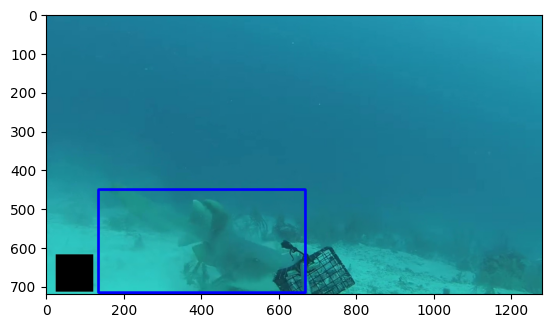

10


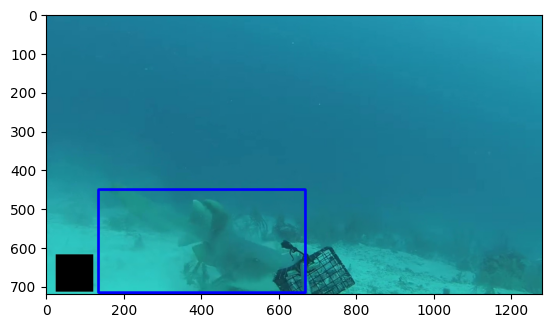

In [11]:
import matplotlib.pyplot as plt
from data.image_processor import ImageProcessor
import cv2
dataset.plot_single_image(10)
anno = dataset[10]
image = anno["image"]
bboxes = anno["bboxes"]
img = ImageProcessor.draw_rect(image, bboxes, show=True)

12
327
294
40
301
258
61
439
207


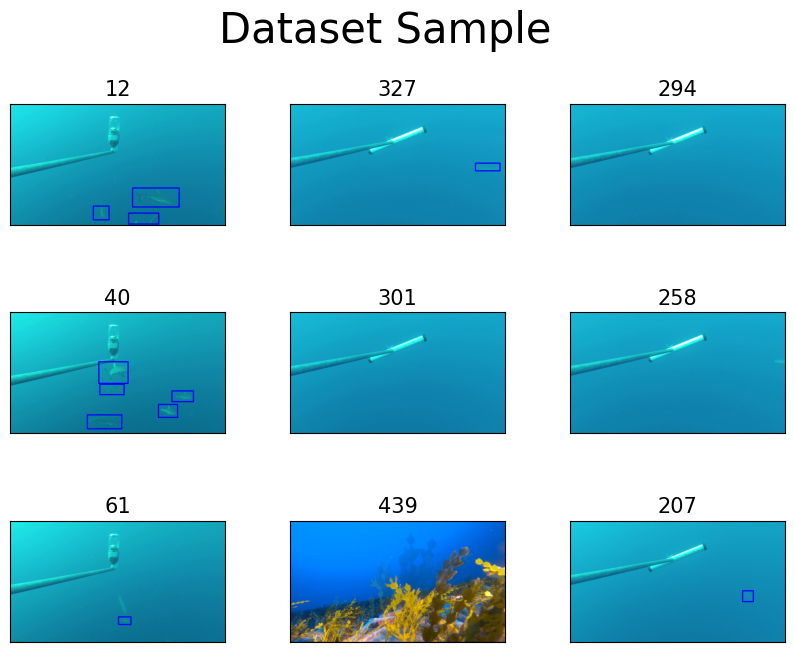

In [7]:
dataset.get_info()

gfp_polynesia1_frame5910.jpg


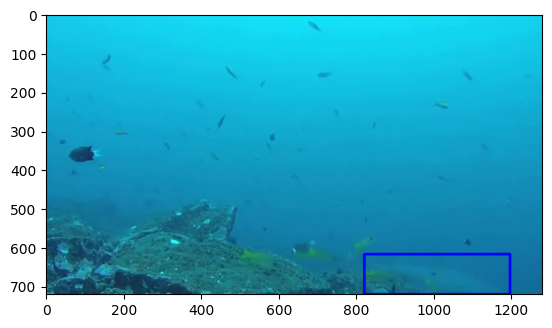

In [7]:
dataset.plot_single_image(2960)